## Baseline Model Pipeline : Titanic Machine Learning from Disaster 

This is the baseline kernel (automatically generated by Bot: AIsha). In this kernel, an end to end classification pipeline is implemented.

### Contents 

1. Prepare Environment  
2. Dataset Preparation  
3. Data Preprocessing   
4. Modelling   
&nbsp;&nbsp;&nbsp;&nbsp; 4.1 Logistic Regression  
&nbsp;&nbsp;&nbsp;&nbsp; 4.2 Random Forest  
&nbsp;&nbsp;&nbsp;&nbsp; 4.3 Extereme Gradient Boosting  
5. Feature Importance   
6. Creating Submission  

## Step 1: Prepare Environment
Lets load the required libraries to be used

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from xgboost import plot_importance
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns 
import xgboost as xgb 
import pandas as pd
import numpy as np 
import itertools

## Step 2: Dataset Preparation
Load the train and test dataset into memory

In [2]:
## read dataset
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv("../input/test.csv")

## get predictor and target variables
_target = "Survived"
_id = "PassengerId" 
Y = train_df[_target]
distinct_Y = Y.value_counts().index
test_id = test_df[_id]

## drop the target and id columns
train_df = train_df.drop([_target, _id], axis=1)
test_df = test_df.drop([_id], axis=1)

tag = "num"
textcol = "text"

Lets look at the dataset snapshot and summary

In [3]:
## snapshot of train and test
train_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
## summary of train and test
# if tag != "text":
train_df.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


Lets plot the distribution of target variable

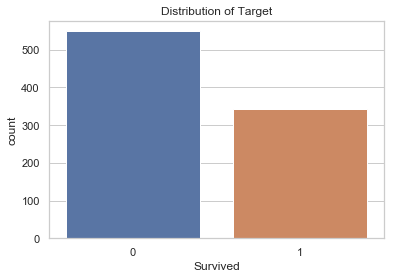

In [5]:
tar_dist = dict(Counter(Y.values))

xx = list(tar_dist.keys())
yy = list(tar_dist.values())

sns.set(style="whitegrid")
ax = sns.barplot(x=xx, y=yy)
ax.set_title('Distribution of Target')
ax.set_ylabel('count');
ax.set_xlabel(_target);

### Missing Value Counts

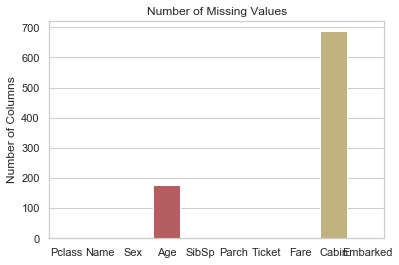

In [6]:
mcount = train_df.isna().sum()
xx = mcount.index 
yy = mcount.values

sns.set(style="whitegrid")
ax = sns.barplot(x=xx, y=yy)
ax.set_title('Number of Missing Values')
ax.set_ylabel('Number of Columns');

### Variable Correlations 

Lets plot the correlations among the variables

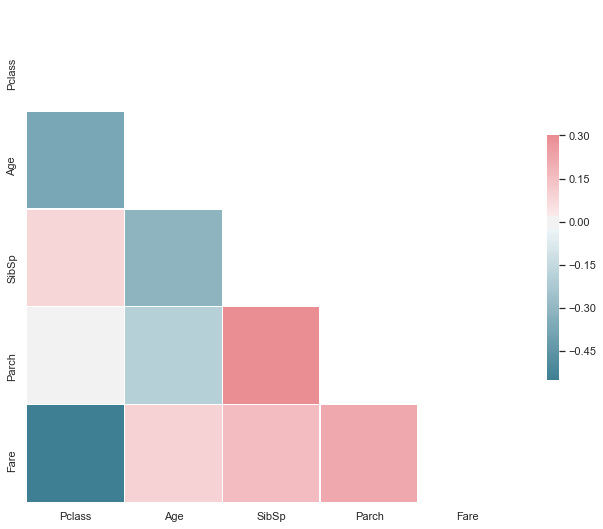

In [7]:
corr = train_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Step 3: Data Preprocessing

In the data preprocessing step, we will perform label encoding of categorical variables and handle missing values.

### 3.1 Label Encoding
In this step, convert the categorical variables into label encoded forms 

In [8]:
if tag != "text":
    columns = train_df.columns
    num_cols = train_df._get_numeric_data().columns
    cat_cols = list(set(columns) - set(num_cols))

    for col in cat_cols: 
        le = LabelEncoder()
        le.fit(list(train_df[col].values) + list(test_df[col].values))
        train_df[col] = le.transform(list(train_df[col].values))
        test_df[col] = le.transform(list(test_df[col].values))

if Y.dtype.name == "object":
    le = LabelEncoder()
    Y = le.fit_transform(Y.values)

### 3.2 Missing Values Treatment

Handle the missing values, for continuous variables, replace by mean. For categorical variables, replace by mode

In [9]:
if tag != "text":
    ## for numerical columns, replace the missing values by mean
    train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].mean())
    test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].mean())

    ## for categorical columns, replace the missing values by mode
    train_df[cat_cols] = train_df[cat_cols].fillna(train_df[cat_cols].mode())
    test_df[cat_cols] = test_df[cat_cols].fillna(test_df[cat_cols].mode())

### 3.3 Feature Engineering 

In this section, we will create relevant features which can be used in the modelling

In [10]:
if tag == "text":
    tfidf = TfidfVectorizer(min_df=3,  max_features=None, analyzer='word', 
                        token_pattern=r'\w{1,}', stop_words = 'english')
    tfidf.fit(list(train_df[textcol].values))
    xtrain =  tfidf.transform(train_df[textcol].values) 
    xtest =  tfidf.transform(test_df[textcol].values)
else:
    xtrain = train_df
    xtest = test_df

### 3.4 Train and Validation sets split

Create the training and validation sets for training the model and validating it

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(xtrain, Y, test_size=0.20, random_state=2018)

## Step 4 : Create baseline model

Next step is the modelling step, lets start with the simple linear model 

### 4.1 : Logistic Regression

Train a binary classifier logistic regression

In [12]:
model = LogisticRegression()
model.fit(X_train, y_train)
valp = model.predict(X_valid)
pred = model.predict(xtest)

auc = roc_auc_score(y_valid, valp)
print('AUC:', auc)

AUC: 0.8176630434782608


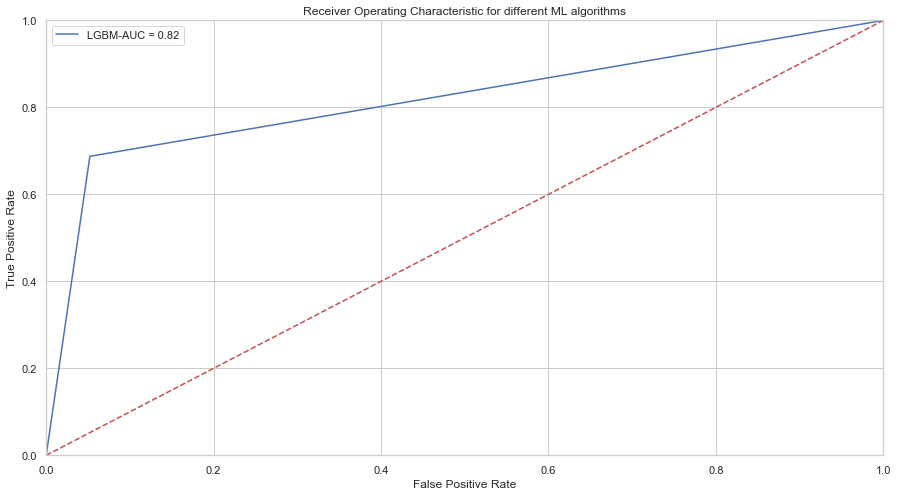

In [13]:
fpr, tpr, thresholds = roc_curve(y_valid, valp)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15,8))
plt.title('Receiver Operating Characteristic for different ML algorithms')
plt.plot(fpr, tpr, 'b', label = 'LGBM-AUC = %0.2f' % roc_auc)
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

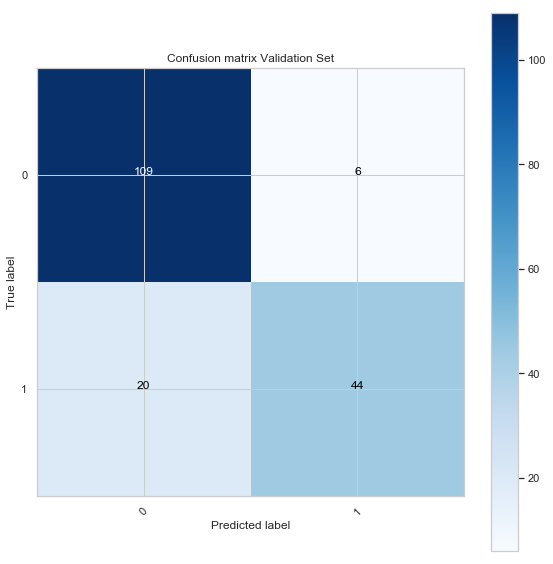

In [14]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set')
plt.show()

### 4.2 : Random Forest Classifier

Now, lets train a tree based model : random forest

In [15]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
valp = model.predict(X_valid)
pred = model.predict(xtest)

auc = roc_auc_score(y_valid, valp)
print('AUC:', auc)

AUC: 0.7881114130434782


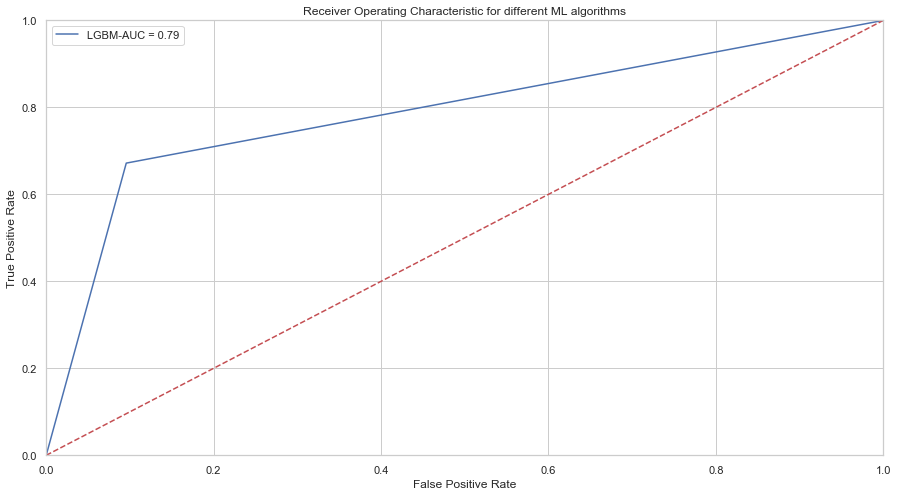

In [16]:
fpr, tpr, thresholds = roc_curve(y_valid, valp)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15,8))
plt.title('Receiver Operating Characteristic for different ML algorithms')
plt.plot(fpr, tpr, 'b', label = 'LGBM-AUC = %0.2f' % roc_auc)
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

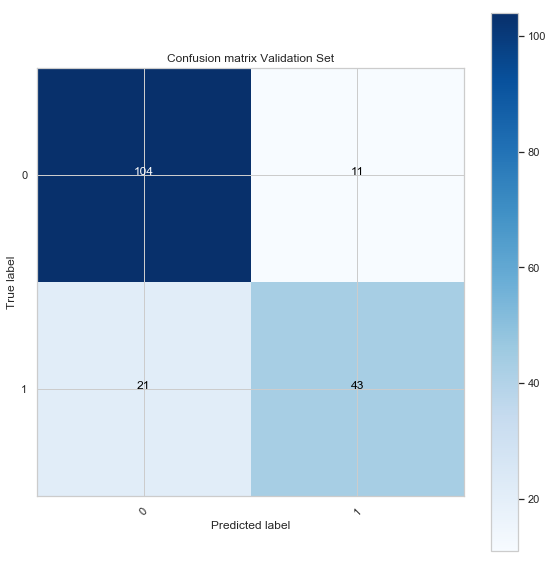

In [17]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set')
plt.show()

### 4.3 : xgBoost Classifier

Lets train the extereme gradient boosting : xgboost classifier

In [18]:
model = xgb.XGBClassifier(n_estimators=300, learning_rate=0.01)
model.fit(X_train, y_train)
valp = model.predict(X_valid)
pred = model.predict(xtest)

auc = roc_auc_score(y_valid, valp)
print('AUC:', auc)

AUC: 0.7699048913043478


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


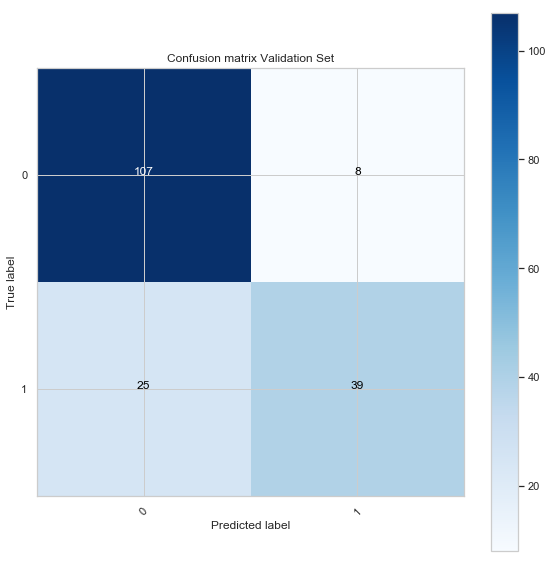

In [19]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set')
plt.show()

## Step 5: Feature Importance

Lets look at some of the important features

<Figure size 1440x1152 with 0 Axes>

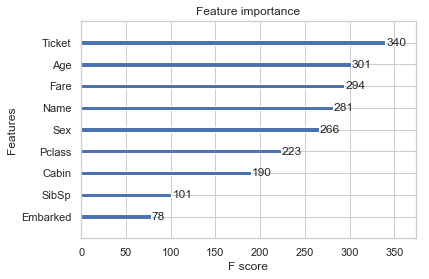

In [20]:
plt.figure(figsize=(20,16));
plot_importance(model, max_num_features=10);

## Step 6 : Create Submission File

Finally, create the submission file from the extereme graident boosting model

In [21]:
sub = pd.DataFrame()
sub[_id] = test_id
sub[_target] = pred
sub.to_csv("baseline_submission.csv", index=False)
sub.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
